# Keyword-Based News Classification (Short Descriptions Only)

This notebook builds a **simple keyword-driven baseline** on the Kaggle *News Category Dataset* using only the `short_description` field, restricted to four categories: **POLITICS, TRAVEL, SPORTS, HOME & LIVING**.


In [1]:
from pathlib import Path
import re
import math
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

DATA_PATH = Path("News_Category_Dataset_v3.json")  
CATEGORIES = ["POLITICS", "TRAVEL", "SPORTS", "HOME & LIVING"]
SAMPLES_PER_CAT = 1000
TEST_SIZE = 0.2
RANDOM_STATE = 42

assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH.resolve()} — please update DATA_PATH."

## 1) Load & Prepare Dataset
- Keep only the four categories
- Retain `short_description` and `category`
- Balance to **1000 samples / category**
- Stratified **80/20** split

In [2]:
df = pd.read_json(DATA_PATH, lines=True)
df = df[df["category"].isin(CATEGORIES)][["short_description", "category"]].dropna()

# Balance
balanced = (
    df.groupby("category", group_keys=False)
      .apply(lambda x: x.sample(n=SAMPLES_PER_CAT, random_state=RANDOM_STATE))
      .reset_index(drop=True)
)

train_df, test_df = train_test_split(
    balanced,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=balanced["category"],
)

print("Counts (train):")
print(train_df["category"].value_counts())
print("\nCounts (test):")
print(test_df["category"].value_counts())

Counts (train):
category
TRAVEL           800
SPORTS           800
HOME & LIVING    800
POLITICS         800
Name: count, dtype: int64

Counts (test):
category
HOME & LIVING    200
POLITICS         200
TRAVEL           200
SPORTS           200
Name: count, dtype: int64


C:\Users\DuaaHilal\AppData\Local\Temp\ipykernel_24300\1560831371.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=SAMPLES_PER_CAT, random_state=RANDOM_STATE))


## 2) Text Preprocessing & Tokenization
- Lowercase
- Keep word characters (A–Z, a–z, 0–9, underscore)
- Remove English stopwords
- Return tokens

In [3]:
STOPWORDS = set("""
a an and are as at be by for from has he in is it its of on or that the to was were will with you your our not this those these their them they we us it's it's.
""".split())

def tokenize(text: str):
    words = re.findall(r"\b\w+\b", str(text).lower())
    return [w for w in words if w not in STOPWORDS and len(w) > 1]

print(tokenize("This is a SAMPLE short description about Travel & sports!"))

['sample', 'short', 'description', 'about', 'travel', 'sports']


## 3) Word Frequencies per Category (Train Only)

In [4]:
cat_to_counter = {}
for cat in CATEGORIES:
    texts = train_df.loc[train_df.category == cat, "short_description"].tolist()
    tokens = [tok for t in texts for tok in tokenize(t)]
    cat_to_counter[cat] = Counter(tokens)

for cat, ctr in cat_to_counter.items():
    print(cat, "→", len(ctr), "unique tokens")
    print("Top 10:", ctr.most_common(10))
    print()

POLITICS → 3696 unique tokens
Top 10: [('trump', 119), ('but', 74), ('have', 71), ('president', 68), ('his', 66), ('said', 59), ('about', 44), ('new', 38), ('donald', 36), ('no', 36)]

TRAVEL → 5005 unique tokens
Top 10: [('but', 114), ('can', 101), ('travel', 77), ('there', 75), ('all', 74), ('one', 71), ('have', 67), ('if', 67), ('world', 67), ('when', 66)]

SPORTS → 3239 unique tokens
Top 10: [('his', 81), ('all', 53), ('game', 44), ('have', 42), ('but', 40), ('first', 38), ('after', 37), ('team', 34), ('said', 34), ('one', 33)]

HOME & LIVING → 3477 unique tokens
Top 10: [('home', 131), ('have', 126), ('can', 92), ('more', 69), ('one', 66), ('out', 66), ('if', 65), ('do', 65), ('re', 63), ('what', 57)]



## 4) Simple Text-Clouds 

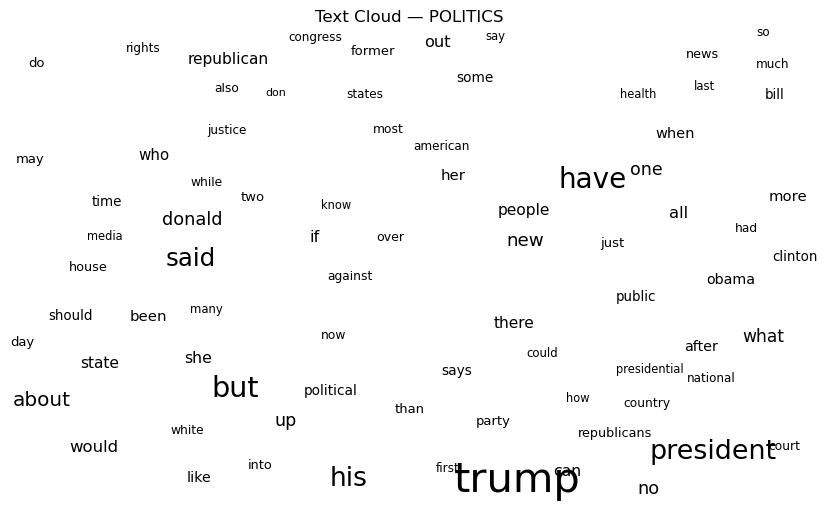

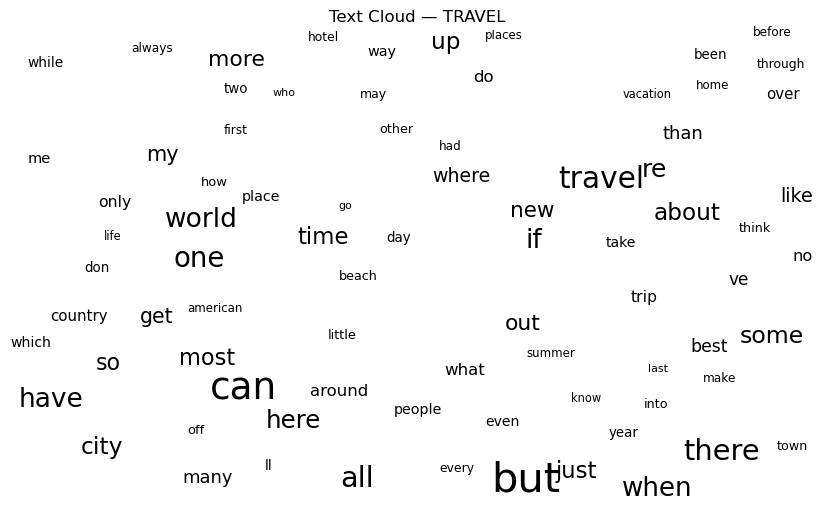

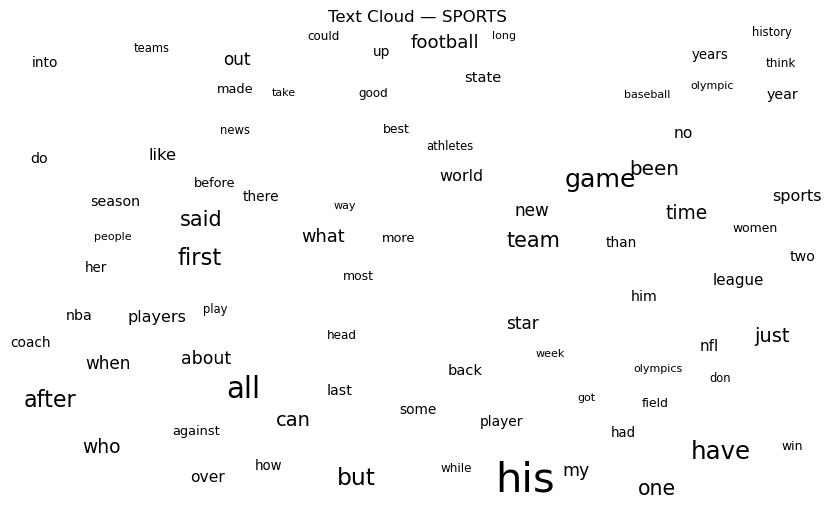

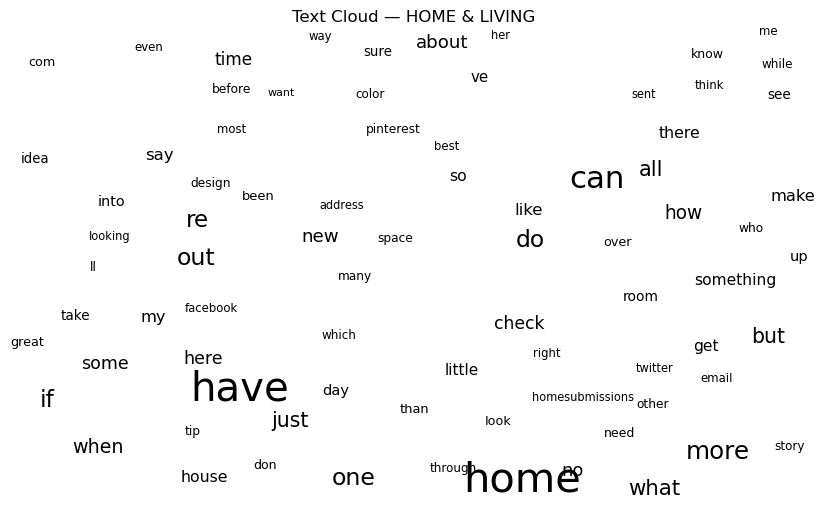

Saved text clouds in: \mnt\data\news_keyword_outputs


In [5]:
import random

def plot_text_cloud(counter: Counter, title: str, topn: int = 80, seed: int = 0, savepath: Path = None):
    random.seed(seed)
    items = counter.most_common(topn)
    if not items:
        print(f"No words to plot for {title}")
        return
    words, freqs = zip(*items)
    sizes = np.array(freqs, dtype=float)
    sizes = 8 + 22 * (sizes - sizes.min()) / (sizes.max() - sizes.min() + 1e-9)  

    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.axis('off')
    
    positions = []
    for i, w in enumerate(words):
        placed = False
        tries = 0
        while not placed and tries < 200:
            x, y = random.random(), random.random()
            placed = True
            for (px, py, ps, text) in positions:
                if abs(x - px) < 0.06 and abs(y - py) < 0.06:
                    placed = False
                    break
            tries += 1
        positions.append((x, y, sizes[i], w))
    for (x, y, s, w) in positions:
        plt.text(x, y, w, fontsize=float(s), ha='center', va='center', transform=plt.gca().transAxes)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
    plt.show()

OUT_DIR = Path("/mnt/data/news_keyword_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

for cat, ctr in cat_to_counter.items():
    plot_text_cloud(ctr, f"Text Cloud — {cat}", topn=80, seed=RANDOM_STATE,
                    savepath=OUT_DIR / f"textcloud_{cat.replace(' & ', '_and_')}.png")

print(f"Saved text clouds in: {OUT_DIR}")

In [17]:
!pip install wordcloud

In [18]:
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
import nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DuaaHilal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


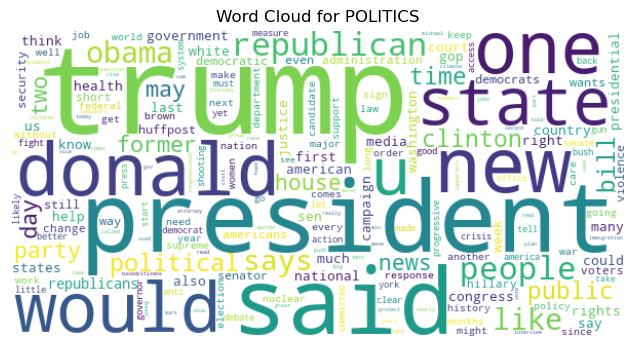

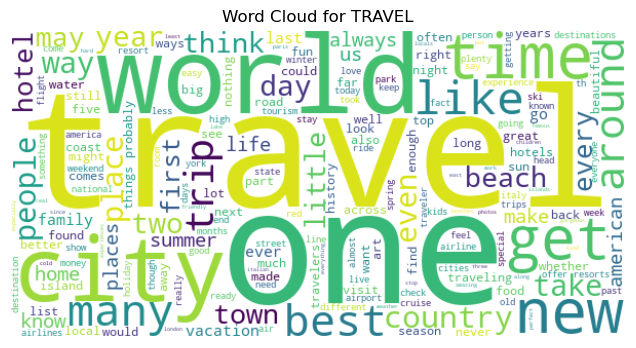

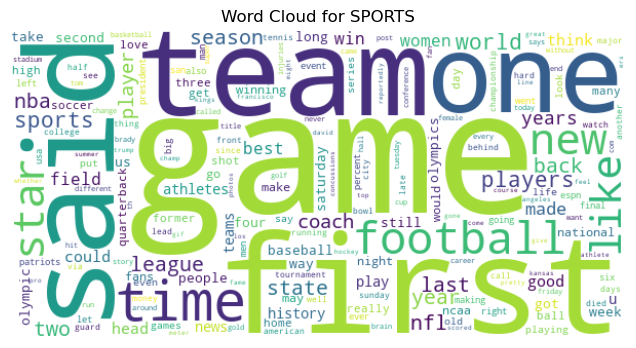

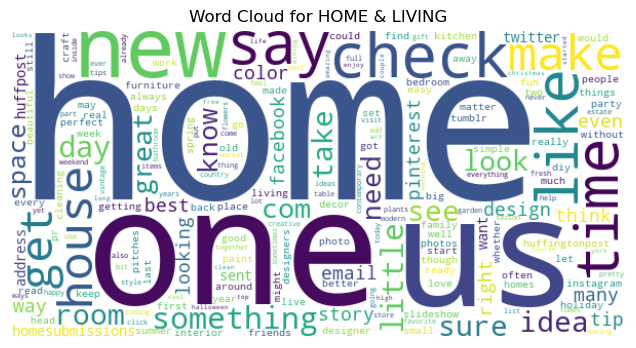


Category: POLITICS
Top 10 words: ['trump', 'president', 'said', 'new', 'donald', 'one', 'would', 'state', 'u', 'republican']
Top 20 words: ['trump', 'president', 'said', 'new', 'donald', 'one', 'would', 'state', 'u', 'republican', 'people', 'like', 'obama', 'says', 'political', 'clinton', 'time', 'public', 'bill', 'may']
Top 30 words: ['trump', 'president', 'said', 'new', 'donald', 'one', 'would', 'state', 'u', 'republican', 'people', 'like', 'obama', 'says', 'political', 'clinton', 'time', 'public', 'bill', 'may', 'former', 'two', 'party', 'day', 'news', 'house', 'republicans', 'also', 'white', 'country']
Top 40 words: ['trump', 'president', 'said', 'new', 'donald', 'one', 'would', 'state', 'u', 'republican', 'people', 'like', 'obama', 'says', 'political', 'clinton', 'time', 'public', 'bill', 'may', 'former', 'two', 'party', 'day', 'news', 'house', 'republicans', 'also', 'white', 'country', 'court', 'states', 'first', 'much', 'congress', 'justice', 'american', 'rights', 'national', '

In [19]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    words = re.findall(r"[a-z]+", text)  
    return [w for w in words if w not in stop_words]
category_word_counts = {}
category_wordclouds = {}
top_words_per_category = {}

for cat in CATEGORIES:
    texts = train_df.loc[train_df["category"] == cat, "short_description"]
    
    all_words = [word for desc in texts for word in clean_text(desc)]
    
    counter = Counter(all_words)
    category_word_counts[cat] = counter
    
    wc = WordCloud(width=600, height=300, background_color="white").generate_from_frequencies(counter)
    category_wordclouds[cat] = wc
    
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {cat}")
    plt.show()
    
  
    top_words_per_category[cat] = [w for w, _ in counter.most_common(100)]

cutoffs = [10, 20, 30, 40, 50]

for cat in CATEGORIES:
    print(f"\nCategory: {cat}")
    for n in cutoffs:
        top_n_words = top_words_per_category[cat][:n]
        print(f"Top {n} words: {top_n_words}")


## 5) Build Frequent Word Sets
store the **top-N words** per category in sets for fast overlap scoring.

In [6]:
def build_topn_sets(cat_to_counter, topn: int):
    top_sets = {}
    for cat, ctr in cat_to_counter.items():
        top_sets[cat] = set([w for w, _ in ctr.most_common(topn)])
    return top_sets

print(build_topn_sets(cat_to_counter, 10))

{'POLITICS': {'trump', 'donald', 'no', 'his', 'but', 'about', 'new', 'said', 'have', 'president'}, 'TRAVEL': {'travel', 'when', 'if', 'but', 'all', 'have', 'there', 'world', 'can', 'one'}, 'SPORTS': {'first', 'team', 'his', 'but', 'all', 'after', 'said', 'have', 'game', 'one'}, 'HOME & LIVING': {'more', 'if', 'out', 'have', 'what', 'can', 'do', 'one', 're', 'home'}}


## 6) Keyword-Based Classifier
Classification = count overlaps between a test item's token set and each category's frequent-word set.

**Tie rule**:
- Option A (default): choose randomly among ties (stable with RANDOM_STATE)
- Option B: return `'unknown'` for ties.
Adjust `RETURN_UNKNOWN_ON_TIE` as needed.

In [7]:
rng = np.random.default_rng(RANDOM_STATE)
RETURN_UNKNOWN_ON_TIE = False 

def classify_text(text: str, top_sets: dict) -> str:
    toks = set(tokenize(text))
    scores = {cat: len(toks & wset) for cat, wset in top_sets.items()}
    max_score = max(scores.values())
    best = [c for c, s in scores.items() if s == max_score]
    if len(best) == 1:
        return best[0]
    if RETURN_UNKNOWN_ON_TIE:
        return "unknown"
    return rng.choice(best)

demo_sets = build_topn_sets(cat_to_counter, 10)
print(classify_text("election votes senate campaign", demo_sets))

POLITICS


## 7) Accuracy vs. Top-N  run the classifier for N in `[10, 20, 30, 50, 75, 100]` and compute **accuracy**.

In [8]:
TOPS = [10, 20, 30, 50, 75, 100]
results = {}

y_true = test_df["category"].tolist()
texts_test = test_df["short_description"].tolist()

for n in TOPS:
    sets_n = build_topn_sets(cat_to_counter, n)
    preds = [classify_text(t, sets_n) for t in texts_test]
    acc = accuracy_score(y_true, preds)
    results[n] = acc
    print(f"Top {n:>3} words → Accuracy: {acc:.4f}")

results

Top  10 words → Accuracy: 0.3538
Top  20 words → Accuracy: 0.3837
Top  30 words → Accuracy: 0.4238
Top  50 words → Accuracy: 0.4625
Top  75 words → Accuracy: 0.4750
Top 100 words → Accuracy: 0.4838


{10: 0.35375, 20: 0.38375, 30: 0.42375, 50: 0.4625, 75: 0.475, 100: 0.48375}

## 8) Plot Accuracy Curve

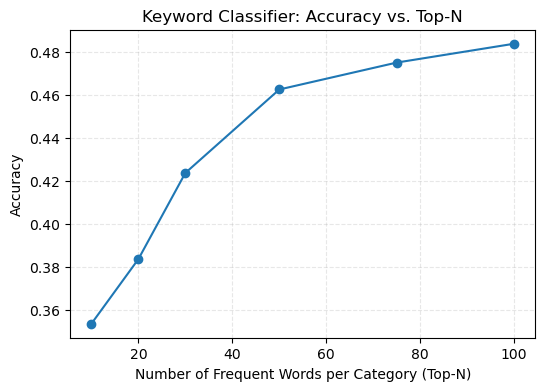

Saved plot to: \mnt\data\news_keyword_outputs\accuracy_vs_topn.png


In [9]:
xs = list(results.keys())
ys = [results[x] for x in xs]
plt.figure(figsize=(6,4))
plt.plot(xs, ys, marker='o')
plt.xlabel('Number of Frequent Words per Category (Top-N)')
plt.ylabel('Accuracy')
plt.title('Keyword Classifier: Accuracy vs. Top-N')
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig(OUT_DIR / "accuracy_vs_topn.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved plot to: {OUT_DIR / 'accuracy_vs_topn.png'}")

## 9) Per-Category Snapshot 

In [10]:
CHOSEN_N = 50
sets_chosen = build_topn_sets(cat_to_counter, CHOSEN_N)

def overlap_scores(text):
    toks = set(tokenize(text))
    return {cat: len(toks & s) for cat, s in sets_chosen.items()}

by_true = defaultdict(list)
for row in test_df.itertuples(index=False):
    sc = overlap_scores(row.short_description)
    by_true[row.category].append(sc)

avg_scores = {}
for cat in CATEGORIES:
    mats = by_true[cat]
    if mats:
        keys = list(sets_chosen.keys())
        avg_scores[cat] = {k: np.mean([m[k] for m in mats]) for k in keys}

pd.DataFrame(avg_scores).T

,POLITICS,TRAVEL,SPORTS,HOME & LIVING
POLITICS,1.790,1.145,1.165,1.145
TRAVEL,1.965,2.780,2.045,2.465
SPORTS,1.020,0.975,1.390,0.910
HOME & LIVING,1.595,2.000,1.595,2.550


In [11]:
import json
for n in TOPS:
    sets_n = build_topn_sets(cat_to_counter, n)
    payload = {cat: sorted(list(words)) for cat, words in sets_n.items()}
    outp = OUT_DIR / f"top_words_top{n}.json"
    with open(outp, 'w', encoding='utf-8') as f:
        json.dump(payload, f, ensure_ascii=False, indent=2)
    print("Saved:", outp)


Saved: \mnt\data\news_keyword_outputs\top_words_top10.json
Saved: \mnt\data\news_keyword_outputs\top_words_top20.json
Saved: \mnt\data\news_keyword_outputs\top_words_top30.json
Saved: \mnt\data\news_keyword_outputs\top_words_top50.json
Saved: \mnt\data\news_keyword_outputs\top_words_top75.json
Saved: \mnt\data\news_keyword_outputs\top_words_top100.json
